# tutorial of retraining DiT model
1. data preparation (convert labelme json to coco json)
2. model fine-tuning
3. model inferencing

```
This tutorial shows how to retrain (fine tune) Mask-RCNN with DiT for document layout analysis 
- this model has been pretrained by PubLayNet for a multi-class detection ('text', 'title', 'list', 'table', 'figure')
- the model will be fine tuned for a single class detection ('segment')
- a small data batch (20 images with labels) will be used to demonstrate the retrain process.
```

- Install cuda and then PyTorch
- Build detectron2 from source ```python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' ```
- Clone unilm repo (DiT is part of unilm) ```git clone https://github.com/microsoft/unilm.git```
  - If you use Python3.10 or above, you will encounter this error **ImportError: cannot import name 'Iterable' from 'collections'**
  - Fix: modify **unilm/dit/object_detection/ditod/table_evaluation/data_structure.py** replace line 6 as ```Iterable from collections.abc```

In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.0 ; cuda:  cu118
detectron2: 0.6


## 1. Data preparation
- PubLayNet sample (20 images)
    - ```https://github.com/ibm-aur-nlp/PubLayNet/tree/master/examples```
- PubLayNet data label (**samples.json**) is natively in COCO format
- For tutorial purpose, labelme labels (rectangle bbox, single class label: "segment") are also created for these 20 images.

### 1.1 convert labelme to COCO format

In [29]:
import labelme2coco

In [35]:
labelme2coco.convert('PubLayNet_data_sample/', 'PubLayNet_data_sample_label/')
# output dataset.json

There are 20 listed files in folder PubLayNet_data_sample/.


Converting labelme annotations to COCO format: 100%|██████████████████████████████████| 20/20 [00:00<00:00, 869.59it/s]
09/23/2023 17:31:12 - INFO - labelme2coco -   Converted annotations in COCO format is exported to PubLayNet_data_sample_label\dataset.json


### However, labelme2coco does not create masks (refered as "segmentation" in json) from bbox

In [42]:
# you can use these functions that I created to create masks from bbox
from coco_bbox2seg import bbox2seg, seg_gen

In [43]:
ct = seg_gen('PubLayNet_data_sample_label/dataset.json')
print(f'created {ct} masks')

created 159 masks


### 1.2 coco data (image+label) visualization

In [3]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [45]:
coco = COCO('./PubLayNet_data_sample_label/dataset.json')
img_dir = './PubLayNet_data_sample'

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [75]:
type(coco.imgs)

dict

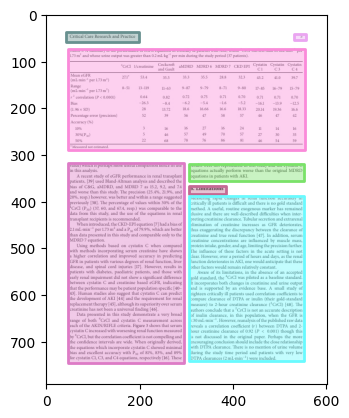

In [71]:
image_id = 1
img = coco.imgs[image_id]
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

#### Listed below is the original label for comparision.
- you can notice the masks in the image above are clearly converted from bounding boxes.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


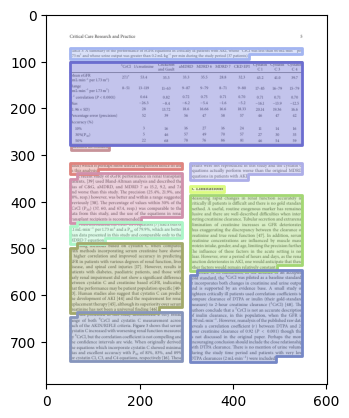

In [73]:
coco = COCO('./PubLayNet_data_sample_label/samples.json')
img_dir = './PubLayNet_data_sample'

image_id = 407967
img = coco.imgs[image_id]
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

## 2. Model fine-tune

In [20]:
# ignore python warning
import os
import warnings
warnings.filterwarnings("ignore")

### 2.1 register custom (new) COCO dataset

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("PubLayNet_samples", {}, "./PubLayNet_data_sample_label/dataset.json", "./PubLayNet_data_sample/")

# # if the dataset is updated, dataset cannot be reloaded. Must be removed first and load it again
# # to remove a dataset from catalog
# from detectron2.data import DatasetCatalog 
# from detectron2.data import MetadataCatalog
# DatasetCatalog.remove("my_dataset_train")
# MetadataCatalog.remove("my_dataset_train")

### 2.2 Model config (DiT + Mask RCNN)

In [3]:
import torch
import detectron2
from unilm.dit.object_detection.ditod import add_vit_config

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
from PIL import Image

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import os
from unilm.dit.object_detection.ditod import MyTrainer

C:\Users\EZ\miniconda3\envs\detectron2_p310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Note: for large dataset training, please consider using python script instead of jupyter notebook

In [5]:
# instantiate config
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file("maskrcnn_dit_base.yaml")
# the command that set the checkpoint output is in this yaml file (last line)

# load dataset
cfg.DATASETS.TRAIN = ("PubLayNet_samples",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

# add model weights URL to config
cfg.MODEL.WEIGHTS = "model/publaynet_dit-b_mrcnn.pth"

# set device
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# train specs
cfg.SOLVER.IMS_PER_BATCH = 1  # batch size
cfg.SOLVER.BASE_LR = 0.00025  # LR
cfg.SOLVER.MAX_ITER = 200    # 10 Epoch = 200 iteration / 20 batches ; 20 batches = (20 Samples / 1 Batch Size)
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # the training dataset only contains 1 class ('segment')

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [09/23 19:06:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/23 19:06:18 d2.data.datasets.coco]: Loaded 20 images in COCO format from ./PubLayNet_data_sample_label/dataset.json
[09/23 19:06:18 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  segment   | 159          |
|            |              |
[09/23 19:06:18 d2.data.build]: Using training sampler TrainingSampler
[09/23 19:06:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/23 19:06:18 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[09/23 19:06:18 d2.data.common]: Serialized dataset takes 0.03 MiB
[09/23 19:06:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from model/publaynet_dit-b_mrcnn.pth ...


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[09/23 19:06:19 d2.engine.train_loop]: Starting training from iteration 0
[09/23 19:06:42 d2.utils.events]:  eta: 0:02:48  iter: 19  total_loss: 2.395  loss_cls: 0.3557  loss_box_reg: 0.1363  loss_mask: 0.6871  loss_rpn_cls: 0.6861  loss_rpn_loc: 0.4652    time: 0.8981  last_time: 0.3286  data_time: 0.1576  last_data_time: 0.0006   lr: 2.2625e-06  max_mem: 3356M
[09/23 19:07:05 d2.utils.events]:  eta: 0:02:36  iter: 39  total_loss: 1.969  loss_cls: 0.1811  loss_box_reg: 0.1297  loss_mask: 0.6763  loss_rpn_cls: 0.65  loss_rpn_loc: 0.3669    time: 1.0327  last_time: 0.6472  data_time: 0.0007  last_data_time: 0.0005   lr: 2.0125e-06  max_mem: 3685M
[09/23 19:07:24 d2.utils.events]:  eta: 0:02:14  iter: 59  total_loss: 2.166  loss_cls: 0.2023  loss_box_reg: 0.2281  loss_mask: 0.6672  loss_rpn_cls: 0.6294  loss_rpn_loc: 0.2738    time: 0.9984  last_time: 0.3359  data_time: 0.0006  last_data_time: 0.0005   lr: 1.7625e-06  max_mem: 3691M
[09/23 19:07:46 d2.utils.events]:  eta: 0:01:56  iter: 

#### Note: Use tensorboard to monitor model fine-tuning
- On terminal ```tensorboard --logdir ckpts/```

## 3. Model inferencing

In [4]:
from detectron2.utils.visualizer import ColorMode, Visualizer

### 3.1 fine-tuned model

In [34]:
# instantiate config
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file("maskrcnn_dit_base.yaml")

# add model weights URL to config
cfg.MODEL.WEIGHTS = "./ckpts/model_final.pth"

# threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# only 1 class
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# set device
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

In [35]:
image = cv2.imread('PubLayNet_data_sample/PMC3654277_00006.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

md = MetadataCatalog.get('PubLayNet_samples')
md.set(thing_classes=["segment"])
#md.set(thing_classes=["text","title","list","table","figure"])

namespace(name='PubLayNet_samples',
          json_file='./PubLayNet_data_sample_label/dataset.json',
          image_root='./PubLayNet_data_sample/',
          evaluator_type='coco',
          thing_classes=['segment'])

In [36]:
%%time
output = predictor(image)

CPU times: total: 1.92 s
Wall time: 541 ms


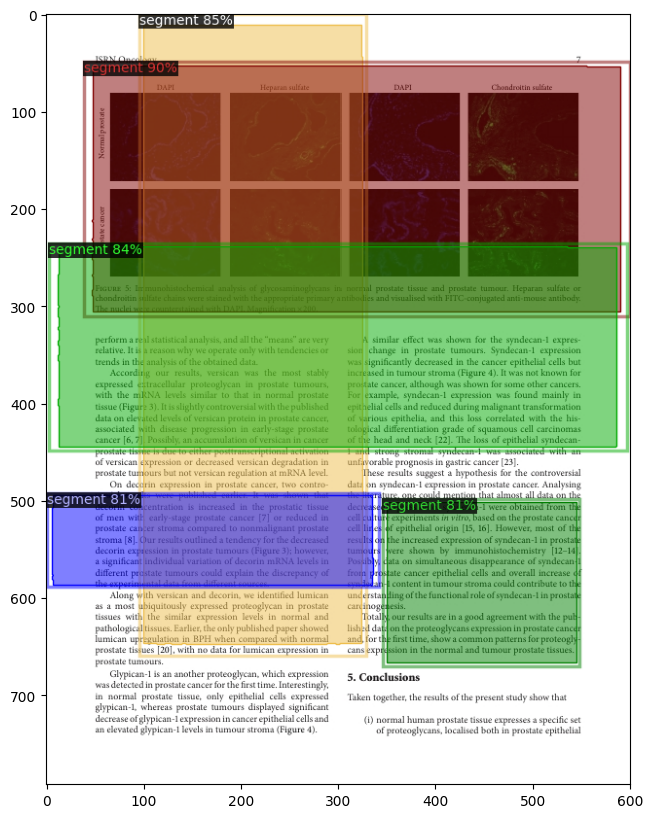

CPU times: total: 594 ms
Wall time: 592 ms


In [37]:
%%time
v = Visualizer(image[:, :, ::-1],
                md,
                scale=1.0,
                instance_mode=ColorMode.SEGMENTATION)
result = v.draw_instance_predictions(output["instances"].to("cpu"))
result_image = result.get_image()[:, :, ::-1]

plt.figure(figsize=(10,10))
plt.imshow(result_image)
plt.axis('on')
plt.show()

### 3.2 original model

In [38]:
register_coco_instances("PubLayNet_samples_og", {}, "./PubLayNet_data_sample_label/sample.json", "./PubLayNet_data_sample/")

In [39]:
# instantiate config
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file("maskrcnn_dit_base.yaml")

# add model weights URL to config
cfg.MODEL.WEIGHTS = "model/publaynet_dit-b_mrcnn.pth"

# threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# 5 class
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

# set device
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

In [40]:
md = MetadataCatalog.get('PubLayNet_samples_og')
#md.set(thing_classes=["segment"])
md.set(thing_classes=["text","title","list","table","figure"])

namespace(name='PubLayNet_samples_og',
          json_file='./PubLayNet_data_sample_label/sample.json',
          image_root='./PubLayNet_data_sample/',
          evaluator_type='coco',
          thing_classes=['text', 'title', 'list', 'table', 'figure'])

In [41]:
%%time
output = predictor(image)

CPU times: total: 1.86 s
Wall time: 535 ms


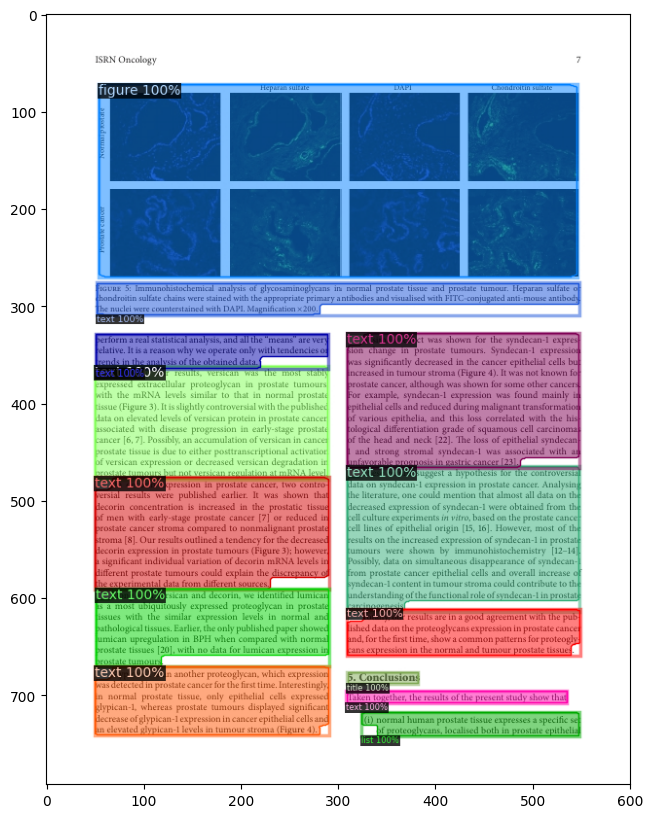

CPU times: total: 609 ms
Wall time: 610 ms


In [42]:
%%time
v = Visualizer(image[:, :, ::-1],
                md,
                scale=1.0,
                instance_mode=ColorMode.SEGMENTATION)
result = v.draw_instance_predictions(output["instances"].to("cpu"))
result_image = result.get_image()[:, :, ::-1]

plt.figure(figsize=(10,10))
plt.imshow(result_image)
plt.axis('on')
plt.show()